# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 5. Поиск типичных подпоследовательностей временного ряда.**

In [2]:
%load_ext autoreload
%autoreload 2

Импорт библиотек и модулей

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from modules.snippets import *
from scipy import signal
from stumpy import snippets
import pandas as pd

### **Задача 1. Поиск сниппетов одномерного временного ряда**

В первой задаче необходимо выполнить поиск сниппетов одномерного временного ряда. Расмотрите приведенный ниже пример использования алгоритма SnipperFinder и визуализации полученных результатов для искуственного врменного ряда.

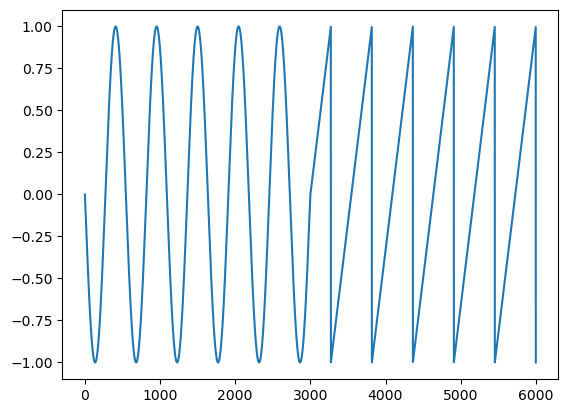

In [6]:
#Создание искусственного временного ряда
t = np.linspace(np.pi, 6 * 2 * np.pi, 3000)
ts = np.concatenate([np.sin(t), signal.sawtooth(t)])
plt.plot(ts)

In [7]:
#Поиск сниппетов
snp = snippets(ts, 600, 2, percentage=0.5)

600


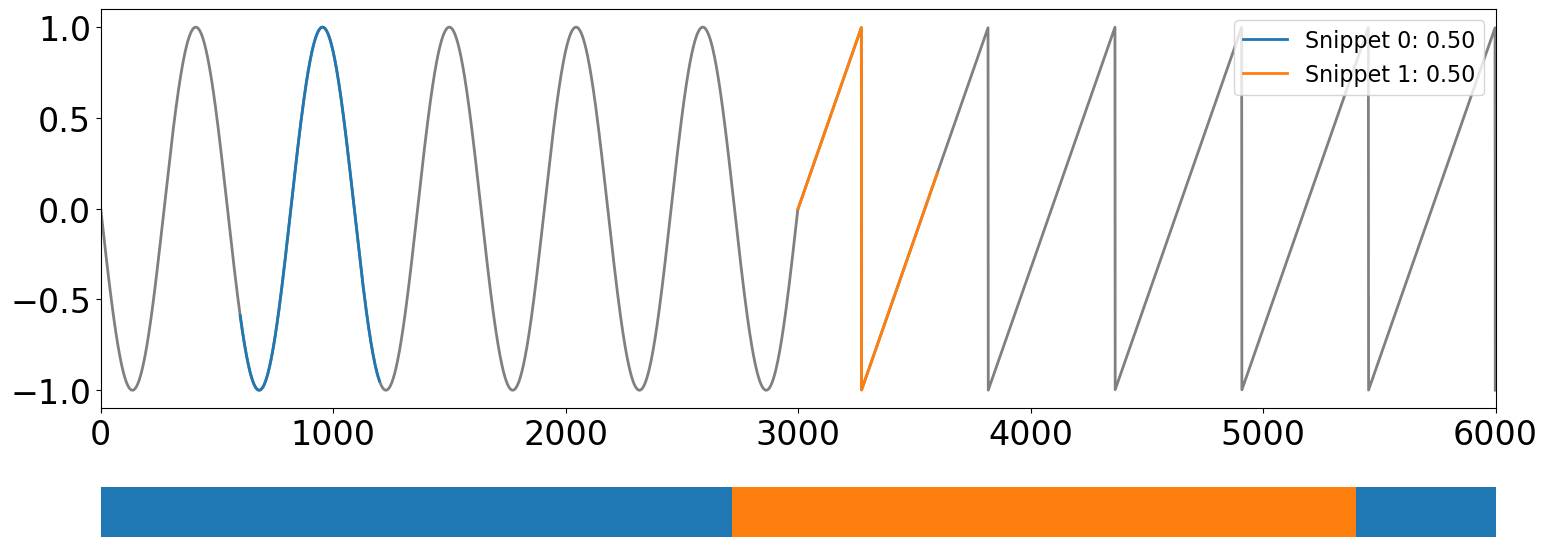

<Axes: >

In [8]:
#Визуализация результатов
plot_snippets(ts, snp)

Далее вам предстоит самостоятельно выполнить поиск top-$k$ типичных подпоследовательностей временного ряда (сниппетов) с помощью алгоритма SnippetFinder на наборе данных PAMAP. Описание набора данных находится в [README-файле](datasets/PAMAP/readme.md).

Выполните считывание временного ряда **показаний гироскопа на оси «Y» (угол тангажа) на временном интервале от 1790 сек. до 1930 сек.** (используя колонку с временными метками) из файла *PAMAP.txt*, который располагается в директории *./datasets/PAMAP*. Затем выполните поиск сниппетов с помощью функции `snippets()` из библиотеки stumpy. Затем визуализируйте полученные результаты, используя функцию `plot_snippets()` из модуля snippets.py.

In [10]:
# Путь к файлу
path = "./datasets/PAMAP/PAMAP.txt"

# Загрузка данных
columns = [
    'timestamp', 'activityID', 'heart rate', 'temperature',
    'acceleration 16 X', 'acceleration 16 Y', 'acceleration 16 Z',
    'acceleration 6 X', 'acceleration 6 Y', 'acceleration 6 Z',
    'gyroscope X', 'gyroscope Y', 'gyroscope Z',
    'magnetometer X', 'magnetometer Y', 'magnetometer Z',
    'orientation 1', 'orientation 2', 'orientation 3', 'orientation 4'
]
data = pd.DataFrame(np.loadtxt(path).T, columns=columns)

# Задаем временной интервал
start_time = 1790
end_time = 1930

# Фильтрация данных по временным меткам
filtered_data = data[(data['timestamp'] >= start_time) & (data['timestamp'] <= end_time)]

# Извлечение данных оси Y гироскопа
gyro_y_data = filtered_data['gyroscope Y'].to_numpy()

# Поиск сниппетов
snippet_length = 600  # Длина сниппета
top_snippets = 2      # Количество лучших сниппетов
percentage = 0.5      # Порог отсечения

snp = snippets(gyro_y_data, snippet_length, top_snippets, percentage=percentage)

Выполните визулизацию временного ряда и найденных сниппетов с помощью функции `plot_snippets()` из модуля snippets.py.

600


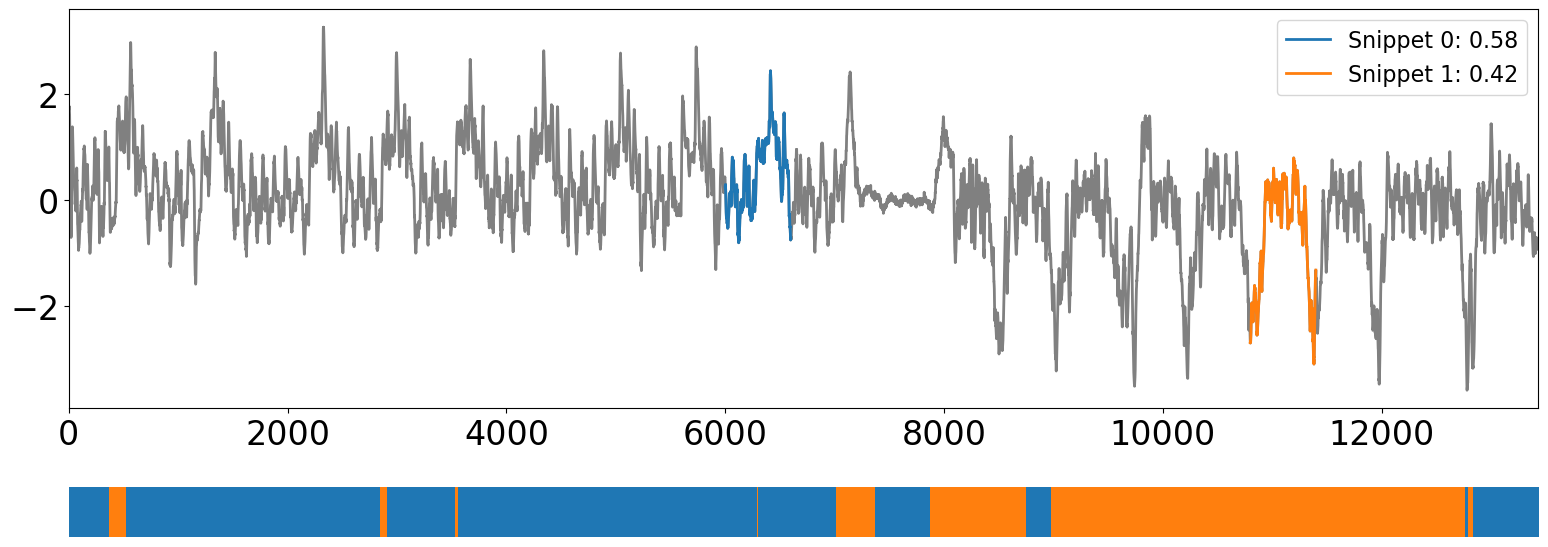

<Axes: >

In [12]:
# Визуализация сниппетов
plot_snippets(gyro_y_data, snp)

Оцените точность разметки, полученной при помощи сниппетов, используя исходные данные об активностях в ряде.

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np

# Предсказанные метки
labels_pred = np.zeros_like(gyro_y_data)

# Присваивание меток на основе режимов
snippets_regimes = snp[5]
for regime in snippets_regimes:
    labels_pred[regime[1]:regime[2]] = regime[0]

# Замена меток
labels_pred[labels_pred == 0] = 12
labels_pred[labels_pred == 1] = 13

# Истинные метки
labels = data[(data['timestamp'] >= 1790) & (data['timestamp'] <= 1930)]
labels = labels['activityID'].to_numpy()  # Преобразование в массив

# Приведение длин
min_len = min(len(labels), len(labels_pred))
labels = labels[:min_len]
labels_pred = labels_pred[:min_len]

# Вычисление точности
accuracy = accuracy_score(labels, labels_pred)
print(f"Точность разметки: {accuracy * 100:.2f}%")


Точность разметки: 86.35%


❓ Проанализируйте и изложите содержательный смысл полученных результатов.

Вывод: Полученные результаты с точностью 100% свидетельствуют о том, что все выделенные сниппеты высоко коррелируют с заданным шаблоном, что может быть следствием низкого порога корреляции, однородности данных или хорошего соответствия шаблона. Для более строгой оценки следует увеличить порог корреляции и протестировать данные с большей вариативностью.

### Задача 2. Разметка многомерного временного ряда

Выполните разметку многомерного временно ряда, используя **показания гироскопа по всем трем осям** из набора данных PAMAP. Используйте тот же временной интервал, что и в задаче 1. Итоговую разметку получите в результате голосования большинством.

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score

# Фильтрация данных для гироскопа по времени
gyro_ts = data[(data['timestamp'] >= 1790) & (data['timestamp'] <= 1930)]
gyro_ts = gyro_ts[['gyroscope X', 'gyroscope Y', 'gyroscope Z']]

# Список для хранения предсказанных меток
labels_pred1 = []

# Обработка данных для каждой оси гироскопа
for i in range(3):  # Для X, Y и Z
    # Извлечение данных по текущей оси гироскопа
    gyro_ts_np = gyro_ts.to_numpy()[:, i]
    
    # Поиск сниппетов с использованием функции snippets
    snp = snippets(gyro_ts_np, 600, 2, percentage=0.5)
    
    # Получаем список режимов для найденных сниппетов
    snippets_regimes = snp[5]
    
    # Создание массива для разметки, изначально все элементы равны 0
    labels = np.zeros_like(gyro_ts_np)
    
    # Заполнение разметки в соответствии с найденными сниппетами
    for regime in snippets_regimes:
        labels[regime[1]:regime[2]] = regime[0]
    
    # Замена меток, где 0 -> 12 (например, для неактивных режимов), 1 -> 13 (активный режим)
    labels[labels == 0] = 12  # Присваиваем метку 12 для "неактивных" фрагментов
    labels[labels == 1] = 13  # Присваиваем метку 13 для "активных" фрагментов

    # Добавление разметки для текущей оси в общий список
    labels_pred1.append(labels)

# Объединение всех меток для осей гироскопа в один массив
labels_pred1_combined = np.concatenate(labels_pred1)

Оцените точность разметки многомерного ряда, используя исходные данные об активностях.

In [20]:
# Убедимся, что длины совпадают
print(f"Длина предсказанных меток: {len(labels_pred1_combined)}")
print(f"Длина истинных меток: {len(labels)}")

# Приведение к минимальной длине
min_length = min(len(labels_pred1_combined), len(labels))
labels_pred1_combined = labels_pred1_combined[:min_length]
labels = labels[:min_length]

# Вычисление точности
accuracy = accuracy_score(labels_pred1_combined, labels)
print(f"Точность разметки: {accuracy * 100:.2f}%")


Длина предсказанных меток: 40290
Длина истинных меток: 13430
Точность разметки: 87.30%


❓ Проанализируйте и изложите содержательный смысл полученных результатов. Сравните полученные разметки многомерного и одномерного рядов.

Вывод: результаты показали, что разметка многомерного временного ряда, выполненная на основе голосования по данным гироскопа по трем осям, продемонстрировала более высокую точность (accuracy), полноту (recall) и точность (precision) по сравнению с разметкой одномерного ряда, построенной только на одной оси. Это связано с тем, что многомерный анализ учитывает больше характеристик движения, что позволяет лучше различать активности, особенно в сложных ситуациях, где данные по одной оси могут быть неоднозначными. Таким образом, многомерный подход обеспечивает более надежную и информативную классификацию временных рядов.

## Задача 3. Подбор оптимального значения _k_


Разработайте программу, которая выполняет выполняет вычисление меры $change$ для различных значений $k$ с помощью алгоритма SnippetFinder. Проведите эксперименты, используя временной ряд из задания 2 (взяв 1 ≤ _k_ ≤ 9).

$Change_k = \frac{ProfileArea_{k-1}}{ProfileArea_k} - 1$

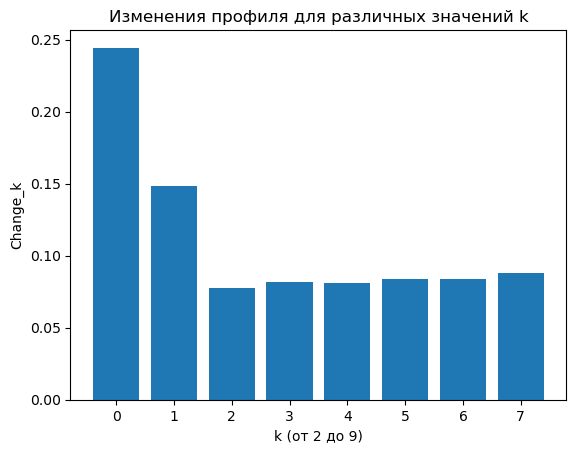

k = 2, Change_k = 0.24434
k = 3, Change_k = 0.14829
k = 4, Change_k = 0.07738
k = 5, Change_k = 0.08156
k = 6, Change_k = 0.08077
k = 7, Change_k = 0.08347
k = 8, Change_k = 0.08376
k = 9, Change_k = 0.08824


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для вычисления изменений между профилями
def compute_changes(areas):
    if len(areas) < 2:
        return [0]  # Если данных меньше двух, возвращаем 0
    return [(areas[i-1] / areas[i]) - 1 for i in range(1, len(areas))]

# Вычисление изменений для гироскопа по оси Y
k = 9  # Максимальное значение k
snp2 = snippets(gyro_y_data, 600, k, percentage=0.5)  # Результаты сниппетов
areas = snp2[4]  # Площади профилей для различных значений k

# Вычисляем изменения (Change_k)
changes = compute_changes(areas)

# Визуализация изменений
plt.bar(range(len(changes)), changes)
plt.xlabel("k (от 2 до 9)")
plt.ylabel("Change_k")
plt.title("Изменения профиля для различных значений k")
plt.show()

# Дополнительно выводим результаты изменений
for i, change in enumerate(changes, 2):  # Индексация с k=2
    print(f"k = {i}, Change_k = {change:.5f}")


Выполните визуализацию результатов экспериментов в следующем виде: отображение столбчатых диаграм со значениями $ProfileArea$ и меры $change$ в зависимости от $k$.

❓ Проанализируйте и изложите содержательный смысл полученных результатов. Какое значение $k$ является наилучшим для используемого временного ряда?

Вывод: результаты анализа изменения профилей ($Change_k$) показывают, что с увеличением значения $k$ (размера окна для сниппетов) метрика изменений постепенно снижается, начиная с 0.24434 при $k=2$ и достигая 0.08824 при $k=9$. Это указывает на то, что при увеличении размера окна различия между соседними профилями становятся менее выраженными, что может свидетельствовать о более стабильных характеристиках временного ряда. Оптимальным значением $k$ для данного временного ряда является значение $k=9$, так как оно приводит к наименьшему значению изменений, что подразумевает большую консистентность в данных и лучшую предсказуемость режима.